In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from scipy.stats import qmc

## Parameters

In [2]:
start_year = 1765
t0 = 2020
time_horizon = 100

sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

In [3]:
species = "Aviation soot"

In [4]:
if species == "Aviation contrails":
    unit_value = 1*10**10
    variables = {
        "time_horizon": (10, 150),
        "sensitivity_rf": (0.5e-12, 4e-12),
        "ratio_erf_rf": (0.23, 0.87),
        "efficacy_erf": (0.12, 1.0)
    }

elif species == "Aviation NOx - ST O3 increase":
    unit_value = 1*10**10
    variables = {
        "time_horizon": (10, 150),
        "sensitivity_rf": (25.1e-12 * (14/46) / 3, 25.1e-12 * (14/46) * 3),
        "ratio_erf_rf": (1, 1.5),
        "efficacy_erf": (0.8, 1.2)
    }

elif species == "Aviation NOx - CH4 decrease and induced":
    unit_value = 1*10**10
    variables = {
        "time_horizon": (10, 150),
        "sensitivity_rf": (-0.83e-9 * 3, -0.83e-9 / 3),
        "ratio_erf_rf": (1, 1.5),
        "efficacy_erf": (0.8, 1.2)
    }
    
n_samples = 100 
dim = len(variables)

sampler = qmc.LatinHypercube(d=dim)
sample = sampler.random(n=n_samples)

l_bounds = [v[0] for v in variables.values()]
u_bounds = [v[1] for v in variables.values()]
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

df = pd.DataFrame(scaled_sample, columns=variables.keys())
df["time_horizon"] = df["time_horizon"].round().astype(int)

    time_horizon  sensitivity_rf  ratio_erf_rf  efficacy_erf
0             94    6.750316e-11      0.872146      1.126338
1             80    1.639581e-10      0.885725      1.106855
2             66    8.918776e-11      1.147457      0.987497
3             89    1.715914e-10      0.829665      0.802543
4            109    6.910780e-11      0.808623      0.844749
..           ...             ...           ...           ...
95            53    1.027866e-10      0.956684      0.808353
96            38    9.391505e-11      1.050207      1.145283
97            68    1.986062e-10      1.137945      0.838691
98            97    1.237753e-10      0.821778      0.823576
99           125    1.728658e-10      0.805368      1.036814

[100 rows x 4 columns]


In [5]:
species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}

ratr_list = np.zeros(n_samples)

for i in range(0, n_samples):
    
    time_horizon = df["time_horizon"].loc[i]
    sensitivity_rf = float(df["sensitivity_rf"].loc[i])
    ratio_erf_rf = float(df["ratio_erf_rf"].loc[i])
    efficacy_erf = float(df["efficacy_erf"].loc[i])
    
    end_year = t0 + time_horizon
    background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
    model_settings_co2 = {"background_species_quantities": background_species_quantities}
    model_settings = {"background_species_quantities": background_species_quantities}
    
    emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value_co2)
    emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
    radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
    radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
    agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
    
    species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
    radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
    
    gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
    ratr_list[i] = ratr

[1212.80636536 1381.32354321 1611.37821568 1267.66891175 1074.75005947
 2772.42687138 1035.81290139 1975.15494083  889.29788466 1291.13906311
 3066.1378476  1738.17281914 1223.37005446 1051.02370365 1051.02370365
 1182.25432006 1439.39440326  999.74882883 1381.32354321  917.30757662
  935.03195953  873.34572647 1861.63579411 4455.2405487  1651.36013941
 5429.3333231  2070.95740243 1715.55581095 2005.97510307 1134.80127867
 3675.5111668  3339.16205783  966.24508627  857.98911637  947.25830983
 6563.66934914 2256.34758206 1021.06149073 4660.06106525 1066.71617609
  828.92989874 1108.2139247  1945.36919503 3151.28316438 1409.69780404
 1013.85117347 1520.0672523  2484.19194221 2986.12545632 2648.33318776
  986.05572051 1341.0355575  1172.43018075 1099.64257244 3947.25055057
 4269.88338718  873.34572647  979.35701757 2590.91893756 1212.80636536
 1486.62897379 3443.19700985 1153.29109899 1125.78954259 2341.57211908
  929.04365662 1810.04207611 1315.57291076 1611.37821568 1424.3750756
  852.9

In [6]:
df['ratr'] = ratr_list
print(df)

    time_horizon  sensitivity_rf  ratio_erf_rf  efficacy_erf         ratr
0             94    6.750316e-11      0.872146      1.126338  1212.806365
1             80    1.639581e-10      0.885725      1.106855  1381.323543
2             66    8.918776e-11      1.147457      0.987497  1611.378216
3             89    1.715914e-10      0.829665      0.802543  1267.668912
4            109    6.910780e-11      0.808623      0.844749  1074.750059
..           ...             ...           ...           ...          ...
95            53    1.027866e-10      0.956684      0.808353  1916.554313
96            38    9.391505e-11      1.050207      1.145283  2484.191942
97            68    1.986062e-10      1.137945      0.838691  1573.446998
98            97    1.237753e-10      0.821778      0.823576  1182.254320
99           125    1.728658e-10      0.805368      1.036814   959.827093

[100 rows x 5 columns]


In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Variables (logarithm)
if species == "Aviation NOx - CH4 decrease and induced":
    X_log = df[["time_horizon", "sensitivity_rf", "ratio_erf_rf", "efficacy_erf"]].copy()
    X_log["sensitivity_rf"] = -X_log["sensitivity_rf"]
    print(X_log)
    X = np.log(X_log)
    y = np.log(-df["ratr"])
    print(X, y)
else:
    X = np.log(df[["time_horizon", "sensitivity_rf", "ratio_erf_rf", "efficacy_erf"]])
    y = np.log(df["ratr"])

# Linear regression (logarithm)
model = LinearRegression()
model.fit(X, y)

coeffs = model.coef_
intercept = model.intercept_
features = X.columns
equation = f"ratr = {intercept:.4f}"
for i in range(len(features)):
    equation += f" + ({coeffs[i]:.4f}) × {features[i]}"
print("Équation de la régression :")
print(equation)

# Assessment
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred)

print(f"\nR² : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")

Équation de la régression :
ratr = 10.6856 + (-0.7935) × time_horizon + (-0.0007) × sensitivity_rf + (0.0027) × ratio_erf_rf + (0.0004) × efficacy_erf

R² : 0.9999
RMSE : 0.0000


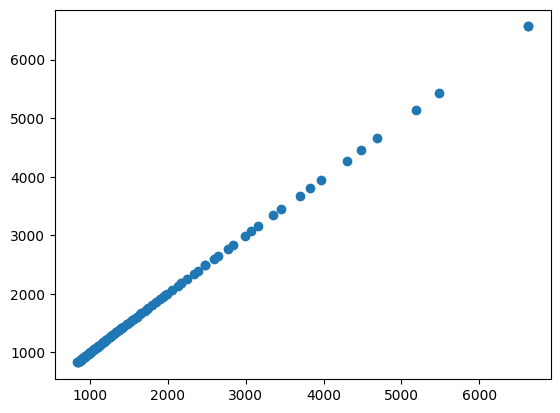

In [8]:
plt.scatter(np.exp(y_pred), np.exp(y))